In [1]:
!pip install -q rapidocr-onnxruntime
!pip install -q pandas opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 13.0 MB/s eta 0:00:00


In [15]:
import cv2
import numpy as np
import re
import os
import pandas as pd
from collections import Counter
from pathlib import Path
from rapidocr_onnxruntime import RapidOCR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# ==============================================================================
# 1. INITIALIZATION & HELPER FUNCTIONS
# ==============================================================================
ocr_engine = RapidOCR()

def parse_value(text):
    """Extracts numeric value and unit from a string."""
    if not isinstance(text, str): return None, None, None
    clean = text.lower().replace('o', '0').replace('l', '1')
    match = re.search(r'(\d+(?:\.\d+)?)\s?([a-zA-Z%]+)?', clean)
    if match:
        val = float(match.group(1))
        unit = match.group(2) if match.group(2) else ""
        return val, unit, text
    return None, None, None

def is_physically_possible(nutrient, val, unit, text):
    """Sanity checks to filter out impossible values."""
    if len(text) > 15 or unit == "%": return False

    if nutrient == "Sodium":
        if unit not in ['mg', 'g']: return False
        if unit == 'g' and val > 10: return False
        return True

    if nutrient == "Energy":
        if unit in ['kcal', 'kj', 'cal', 'cals']: return True
        if unit == "" and val > 10: return True
        return False

    if unit in ['kcal', 'kj', 'cal']: return False
    if unit in ['g', 'mg', 'mcg', '']: return True

    return False

def v_text_formatted(val, unit):
    """Formats value back to string for evaluation."""
    return f"{val}{unit}" if unit else f"{val}"

def find_all_candidates(key_idx, key_box, all_results, used_indices, nutrient_name):
    """Finds all numbers to the right of a label."""
    key_y = (key_box[0][1] + key_box[2][1]) / 2
    key_x = key_box[1][0]

    candidates = []
    for i, item in enumerate(all_results):
        if i == key_idx or i in used_indices: continue
        val_box, val_text = item[0], item[1]
        val_y = (val_box[0][1] + val_box[2][1]) / 2
        val_x = val_box[0][0]

        if val_x < key_x: continue # Must be to the right
        if abs(key_y - val_y) > 20: continue # Vertical drift check

        v_num, v_unit, v_raw = parse_value(val_text)
        if v_num is None: continue

        if is_physically_possible(nutrient_name, v_num, v_unit, val_text):
            candidates.append({
                'val': v_text_formatted(v_num, v_unit),
                'idx': i,
                'x': val_x,
                'key': nutrient_name,
                'vertical_score': abs(key_y - val_y)
            })
    return candidates

def solve_column_clustering(candidates_pool):
    """Finds the vertical column where most numbers align."""
    all_x = [c['x'] for cands in candidates_pool.values() for c in cands]
    if not all_x: return {}

    bins = [round(x / 40) * 40 for x in all_x]
    common = Counter(bins).most_common()
    if not common: return {}

    dominant_x = common[0][0]
    final_results = {}

    for key, cands in candidates_pool.items():
        if not cands: continue
        best_cand = None
        min_dist = float('inf')

        for c in cands:
            dist = abs(c['x'] - dominant_x)
            if dist < 80:
                if dist < min_dist:
                    min_dist = dist
                    best_cand = c
        if best_cand:
            final_results[key] = best_cand

    return final_results

def run_rapidocr_pipeline(image_path):
    """Runs OCR and groups into Key-Value format."""
    img = cv2.imread(image_path)
    if img is None: return ""

    result, _ = ocr_engine(img)
    if not result: return ""

    extracted = {}
    used_indices = set()
    candidates_pool = {}

    target_nutrients = {
        "Energy": ["energy", "kcal", "calories"],
        "Protein": ["protein"],
        "Fat": ["total fat", "fat", "lipids"],
        "Carbohydrate": ["carbohydrate", "carb", "carbs"],
        "Fibre": ["fibre", "fiber", "dietary fiber"],
        "Sodium": ["sodium", "salt"],
    }

    for std_key, aliases in target_nutrients.items():
        for i, item in enumerate(result):
            if i in used_indices: continue
            text, box = item[1].lower(), item[0]

            if any(alias in text for alias in aliases):
                if len(text) > 30: continue

                clean_text = text
                for a in aliases: clean_text = clean_text.replace(a, "")
                v_num, v_unit, _ = parse_value(clean_text)

                if v_num is not None and is_physically_possible(std_key, v_num, v_unit, clean_text):
                    extracted[std_key] = v_text_formatted(v_num, v_unit)
                    used_indices.add(i)
                    break

                cands = find_all_candidates(i, box, result, used_indices, std_key)
                if cands:
                    candidates_pool[std_key] = cands
                    used_indices.add(i)
                    break

    resolved = solve_column_clustering(candidates_pool)
    for k, cand in resolved.items():
        extracted[k] = cand['val']

    return " ".join([f"{k} {v}" for k, v in extracted.items()])

In [ ]:
# ==============================================================================
# 2. EVALUATION METRICS (From your modelling file)
# ==============================================================================
def universal_nutrient_extractor(pred_text, target_key, gt_value=None, window_size=150):
    pred_text = pred_text.lower()
    anchor = target_key.lower()[:3]
    start_idx = pred_text.find(anchor)

    if start_idx == -1: return None
    window = pred_text[start_idx : start_idx + window_size]

    if gt_value:
        clean_gt = re.sub(r'[^\d.]', '', str(gt_value)).strip('.')
        if clean_gt and clean_gt in window:
            return clean_gt

    match = re.search(r'(\d+[\d\.]*)', window)
    if match: return match.group(0).strip('.')
    return None

def calculate_extraction_metrics(pred_str, gt_dict):
    fields_found = 0
    kv_matches = 0

    for gt_k, gt_v in gt_dict.items():
        extracted_val = universal_nutrient_extractor(pred_str, gt_k, gt_value=gt_v, window_size=150)
        if extracted_val is not None:
            fields_found += 1
            clean_gt_v = re.sub(r'[^\d.]', '', str(gt_v)).strip('.')
            if extracted_val == clean_gt_v:
                kv_matches += 1

    total = len(gt_dict)
    return {
        "field_accuracy": fields_found / total if total > 0 else 0,
        "kv_accuracy": kv_matches / total if total > 0 else 0
    }

In [21]:
# ==============================================================================
# 3. EVALUATION RUNNER & VISUALIZER
# ==============================================================================
def evaluate_rapidocr_system_detailed(image_paths, ground_truth_data):
    results_list = []

    for path in tqdm(image_paths, desc="Evaluating RapidOCR"):
        if path not in ground_truth_data: continue

        prediction_str = run_rapidocr_pipeline(path)
        img_metrics = calculate_extraction_metrics(prediction_str, ground_truth_data[path])

        results_list.append({
            "path": path,
            "filename": os.path.basename(path),
            "ground_truth": ground_truth_data[path],
            "prediction": prediction_str,
            "field_acc": img_metrics["field_accuracy"],
            "kv_acc": img_metrics["kv_accuracy"]
        })
    return results_list

def analyze_and_visualize_performance(results_list, top_n=3, bottom_n=3):
    sorted_results = sorted(results_list, key=lambda x: x['kv_acc'], reverse=True)

    print("\n" + "="*60)
    print(f"🌟 TOP {top_n} PERFORMING SAMPLES (Highest KV Accuracy)")
    print("="*60)

    for i, res in enumerate(sorted_results[:top_n]):
        print(f"\nRank #{i+1} | Filename: {res['filename']}")
        print(f"KV Accuracy: {res['kv_acc']:.2%} | Field Discovery: {res['field_acc']:.2%}")
        print(f"Ground Truth: {res['ground_truth']}")
        print(f"Prediction:   {res['prediction']}")
        print("-" * 40)

    print("\n" + "="*60)
    print(f"⚠️ BOTTOM {bottom_n} PERFORMING SAMPLES (Lowest KV Accuracy)")
    print("="*60)

    worst_results = sorted_results[-bottom_n:]
    for i, res in enumerate(worst_results):
        print(f"\nRank #{len(results_list)-bottom_n+i+1} (Worst) | Filename: {res['filename']}")
        print(f"KV Accuracy: {res['kv_acc']:.2%} | Field Discovery: {res['field_acc']:.2%}")
        print(f"Ground Truth: {res['ground_truth']}")
        print(f"Prediction:   {res['prediction']}")

        print("\nInput Image:")
        try:
            display(IPImage(filename=res['path'], width=300))
        except Exception as e:
            print(f"Could not display image: {e}")
        print("-" * 60)

Running evaluation on clean sample of: 16 images


Evaluating RapidOCR:   0%|          | 0/16 [00:00<?, ?it/s]


Final Field-Level Accuracy (Discovery): 82.40%
Final Key-Value Pair Accuracy (Linkage): 58.65%

🌟 TOP 3 PERFORMING SAMPLES (Highest KV Accuracy)

Rank #1 | Filename: proc_0005100000100.jpg
KV Accuracy: 100.00% | Field Discovery: 100.00%
Ground Truth: {'Energy': '2162.0kj', 'Fat': '31.0kcal', 'Fibre': '3.9g', 'Protein Salt': '6.4g'}
Prediction:   Energy 2162.0kj Protein 3.9g Fat 31.0g Carbohydrate 2.5g Fibre 3.9g Sodium 6.4g
----------------------------------------

Rank #2 | Filename: proc_0612322000202.jpg
KV Accuracy: 100.00% | Field Discovery: 100.00%
Ground Truth: {'Energy': '229.0kj', 'Fibre': '1.2g'}
Prediction:   Energy 229.0kj Protein 0.1g Fat 0.6g Carbohydrate 2.0g Fibre 1.2g Sodium 0.1g
----------------------------------------

Rank #3 | Filename: proc_0612322030087.jpg
KV Accuracy: 100.00% | Field Discovery: 100.00%
Ground Truth: {'Carbohydrate': '62.3g', 'Fat': '20.5g', 'Fibre': '5.4g', 'Protein': '7.7g'}
Prediction:   Energy 1992.0kj Protein 7.7g Fat 20.5g Carbohydrate 62

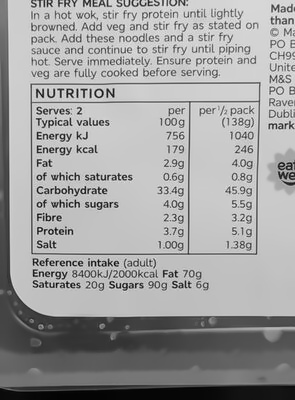

------------------------------------------------------------

Rank #15 (Worst) | Filename: proc_01163575.jpg
KV Accuracy: 33.33% | Field Discovery: 66.67%
Ground Truth: {'Carbohydrate': '3.1g', 'ich sugars Fibre': '0.5g', 'Protein': '0.9g'}
Prediction:   Energy 38.0 Protein 0.9g Carbohydrate 6.2g Fibre 5.2g

Input Image:


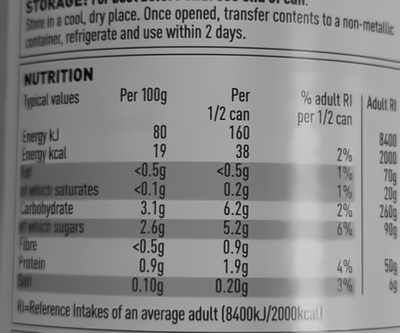

------------------------------------------------------------

Rank #16 (Worst) | Filename: proc_0024000124955.jpg
KV Accuracy: 20.00% | Field Discovery: 60.00%
Ground Truth: {'Carbohydrate :': '12.0g', 'Energy :': '223.0kj', 'Fibre:': '0.4g', 'Protein :': '0.4g', 'Salt :': '0.05g'}
Prediction:   Protein 0.0 Fat 0.0g Carbohydrate 12.0g Fibre 0.0

Input Image:


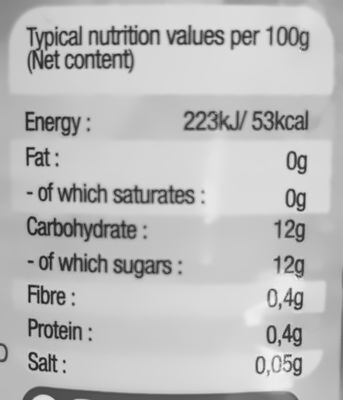

------------------------------------------------------------


In [22]:
# ==============================================================================
# 4. DATA PREPARATION & EXECUTION
# ==============================================================================

# A. Load the Ground Truth
gt_path = '/content/drive/My Drive/AAP_Data/cleaned_rapidocr_gt.csv'
gt_df = pd.read_csv(gt_path)

# B. Format to Dictionary
def convert_json(img_list, df):
    grouped = {}
    for img in img_list:
        rows = df[df['image_path'] == img]
        grouped[img] = {str(r['extracted_label']): str(r['value']) for _, r in rows.iterrows()}
    return grouped

# C. Get Unique Images (They are already validated and filtered!)
unique_images = gt_df['image_path'].unique()

test_targets = convert_json(unique_images, gt_df)
print(f"Running evaluation on clean sample of: {len(unique_images)} images")

# D. Run Pipeline
results = evaluate_rapidocr_system_detailed(unique_images, test_targets)

# E. Display Metrics and Visuals
if results:
    avg_field = sum(r['field_acc'] for r in results) / len(results)
    avg_kv = sum(r['kv_acc'] for r in results) / len(results)

    print(f"\nFinal Field-Level Accuracy (Discovery): {avg_field:.2%}")
    print(f"Final Key-Value Pair Accuracy (Linkage): {avg_kv:.2%}")

    # Show Best/Worst
    analyze_and_visualize_performance(results, top_n=3, bottom_n=3)